In [1]:
# Save and restore models for additional training
# import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn import preprocessing
import sys
import datetime
import matplotlib.pyplot as plt
plt.style.use('ggplot') # use this plot style
%matplotlib inline

In [2]:
print('Python version ' + sys.version)
print('Tensorflow version ' + tf.VERSION)
print('Pandas version ' + pd.__version__)
print('Numpy version ' + np.__version__)

Python version 3.6.8 (tags/v3.6.8:3c6b436a57, Dec 24 2018, 00:16:47) [MSC v.1916 64 bit (AMD64)]
Tensorflow version 1.13.1
Pandas version 0.24.2
Numpy version 1.16.2


In [3]:
def normalize(array):
    u = array.mean()
    s = array.std()
    norm = (array - u) / s
    return u, s, norm

def min_max(array, min=0, max=1):
    X_std = (array - array.min(axis=0)) / (array.max(axis=0) - array.min(axis=0))
    X_scaled = X_std * (max - min) + min
    return X_scaled

In [6]:
# Let's generate 1000 random samples
pool = np.random.rand(10000,1).astype(np.float32)
# Shuffle the samples
np.random.shuffle(pool)
# sample size of 15%
sample = int(1000 * 0.15)
# 15% test
test_x = pool[0:sample]
# 15% validation
valid_x = pool[sample:sample*2]
# 70% training
train_x = pool[sample*2:]
print('Testing data points: ' + str(test_x.shape), type(test_x))
print('Validation data points: ' + str(valid_x.shape))
print('Training data points: ' + str(train_x.shape))
# Let's compute the ouput using 2 for a and 2 for b
test_y = 2.0 * test_x**8 + 1.0 * test_x**6
valid_y = 2.0 * valid_x**8 + 1.0 * valid_x**6
train_y = 2.0 * train_x**8 + 1.0 * train_x**6
# scale x and y (I choose to only scale y since x seemed already to be close enough to min=0, max=1)
#test_x = min_max(test_x)
test_y = min_max(test_y)
#valid_x = min_max(valid_x)
valid_y = min_max(valid_y)
#train_x = min_max(train_x)
train_y = min_max(train_y)
# Normalize x and y (I choose to only normalize y since x seemed already to be close enough to mean=0, std=1)
#u_test_x, s_test_x, test_x = normalize(test_x)
u_test_y, s_test_y, test_y = normalize(test_y)
#u_valid_x, s_valid_x, valid_x = normalize(valid_x)
u_valid_y, s_valid_y, valid_y = normalize(valid_y)
#u_train_x, s_train_x, train_x = normalize(train_x)
u_train_y, s_train_y, train_y = normalize(train_y)

Testing data points: (150, 1) <class 'numpy.ndarray'>
Validation data points: (150, 1)
Training data points: (9700, 1)


In [6]:
df = pd.DataFrame({'train_x':train_x[:,0],'train_y':train_y[:,0]})
df_valid = pd.DataFrame({'valid_x':valid_x[:,0],'valid_y':valid_y[:,0]})
df_test = pd.DataFrame({'test_x':test_x[:,0],'test_y':test_y[:,0]})
df.head()

,train_x,train_y
0,0.732442,-0.080190
1,0.893564,1.399070
2,0.154401,-0.552727
3,0.318130,-0.550908
4,0.740909,-0.040359


In [7]:
df.describe()

,train_x,train_y
count,9700.000000,9.700000e+03
mean,0.500683,6.685552e-08
std,0.291213,1.000051e+00
min,0.000064,-5.527482e-01
25%,0.248534,-5.523573e-01
50%,0.499978,-5.181532e-01
75%,0.756506,4.078898e-02
max,0.999974,3.875861e+00


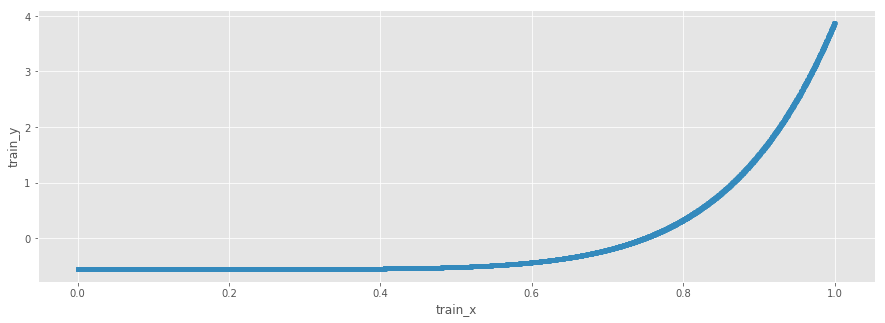

In [8]:
df.plot.scatter(x='train_x', y='train_y', figsize=(15,5))

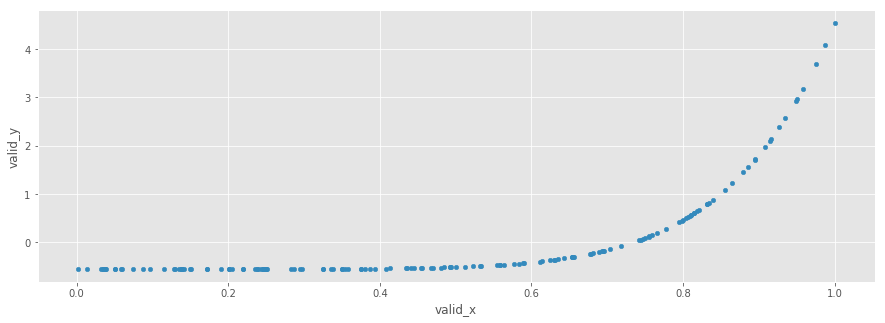

In [9]:
df_valid.plot.scatter(x='valid_x', y='valid_y', figsize=(15,5))

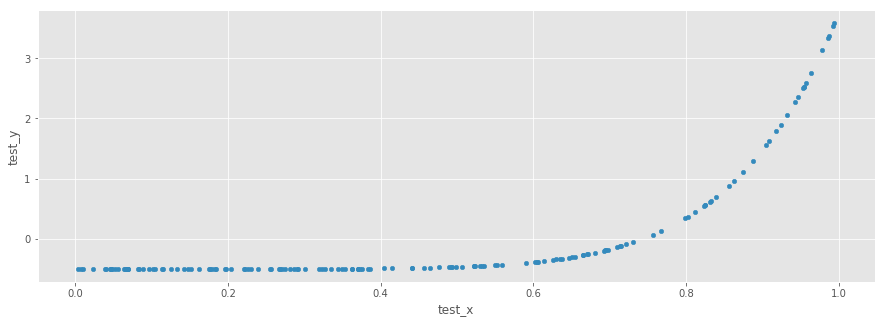

In [10]:
df_test.plot.scatter(x='test_x', y='test_y', figsize=(15,5))

In [11]:
def add_layer(inputs, in_size, out_size, activation_function=None):
    # tf.random_normal([what is the size of your batches, size of output layer])
    Weights = tf.Variable(tf.truncated_normal([in_size, out_size], mean=0.1, stddev=0.1))
    # tf.random_normal([size of output layer])
    biases = tf.Variable(tf.truncated_normal([out_size], mean=0.1, stddev=0.1))
    # shape of pred = [size of your batches, size of output layer]
    pred = tf.matmul(inputs, Weights) + biases
    if activation_function is None:
        outputs = pred
    else:
        outputs = activation_function(pred)
    return outputs

In [12]:
# larger batch sizes help you get to the local minimum faster at a cost of more cpu power
# The strategy is to use batch_size when you cannot fit the entire dataset into memory
# In practice, small to moderate mini-batches (10-500) are generally used
batch_size = 100

In [13]:
# you can adjust the number of neurons in the hidden layers here
hidden_size = 10
# placeholders
# shape=[how many samples do you have, how many input neurons]
x = tf.placeholder(tf.float32, shape=[None, 1], name="01_x")
y = tf.placeholder(tf.float32, shape=[None, 1], name="01_y")
print("shape of x and y:")
print(x.get_shape(),y.get_shape())

shape of x and y:
(?, 1) (?, 1)


In [14]:
# drop out
keep_prob = tf.placeholder(tf.float32)

In [15]:
# create your hidden layers!
h1 = add_layer(x, 1, hidden_size, tf.nn.relu)

# here is where we shoot down some of the neurons
h1_drop = tf.nn.dropout(h1, keep_prob)

# add a second layer
h2 = add_layer(h1_drop, hidden_size, hidden_size, tf.nn.relu)
h2_drop = tf.nn.dropout(h2, keep_prob)

# add a third layer
h3 = add_layer(h2_drop, hidden_size, hidden_size, tf.nn.relu)
h3_drop = tf.nn.dropout(h3, keep_prob)

# add a fourth layer
h4 = add_layer(h3_drop, hidden_size, hidden_size, tf.nn.relu)
h4_drop = tf.nn.dropout(h4, keep_prob)

print("shape of hidden layers:")
print(h1_drop.get_shape(), h2_drop.get_shape(), h3_drop.get_shape(), h4_drop.get_shape())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
shape of hidden layers:
(?, 10) (?, 10) (?, 10) (?, 10)


In [16]:
# Output Layers
pred = add_layer(h4_drop, hidden_size, 1)

print("shape of output layer:")
print(pred.get_shape())

shape of output layer:
(?, 1)


In [17]:
# minimize the mean squared errors.
loss = tf.reduce_mean(tf.square(pred - y))
# pick optimizer
optimizer = tf.train.GradientDescentOptimizer(0.001)
train = optimizer.minimize(loss)

In [73]:
# Create variable to save and restore all of your variables
saver = tf.train.Saver()
# path
save_path = "E:/Model/model_" + datetime.datetime.now().strftime('%Y-%m-%d')

In [74]:
# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [75]:
# Best validation accuracy seen so far.
best_valid_acc = 0.0
# Iteration-number for last improvement to validation accuracy.
last_improvement = 0
# Stop optimization if no improvement found in this many iterations.
require_improvement = 15000

In [80]:
# initialize the variables
init = tf.global_variables_initializer()
# hold step and error values
t = []
# Run your graph
with tf.Session() as sess:
    
    # restore model (no need to initialize variables if restorint model)
    saver.restore(sess, save_path=save_path)
    
    # initialize variables
    sess.run(init)

    # Fit the function.
    for step in range(60000):
        # pull batches at random
        i = np.random.permutation(train_x.shape[0])[:batch_size]
        # get your data
        train_data = {x:train_x[i,:], y:train_y[i,:], keep_prob: 0.98}
        valid_data = {x:valid_x, y:valid_y, keep_prob: 1.0}
        test_data = {x:test_x, y:test_y, keep_prob: 1.0}
        
        # training in progress...
        train_loss, train_pred = sess.run([loss, train], feed_dict=train_data)        
        
        # print every n iterations
        if step%1000==0:
           
            # capture the step and error for analysis
            valid_loss = sess.run(loss, feed_dict=valid_data) 
            t.append((step, train_loss, valid_loss))    
            
            # get snapshot of current training and validation accuracy       
            train_acc = accuracy.eval(train_data)
            valid_acc = accuracy.eval(valid_data)           

            # If validation accuracy is an improvement over best-known.
            if valid_acc > best_valid_acc:
                # Update the best-known validation accuracy.
                best_valid_acc = valid_acc
                
                # Set the iteration for the last improvement to current.
                last_improvement = step
                
                # Save model to disk
                saver.save(sess, save_path=save_path)               
                # Flag when ever an improvement is found
                improved_str = '*'
            else:
                # An empty string to be printed below.
                # Shows that no improvement was found.
                improved_str = ''   
                
            print("Training loss at step %d: %f %s" % (step, train_loss, improved_str))        
            print("Validation %f" % (valid_loss))            
                
            # If no improvement found in the required number of iterations.
            if step - last_improvement > require_improvement:
                print("No improvement found in a while, stopping optimization.")
                # Break out from the for-loop.
                break 
            
    # here is where you see how good of a Data Scientist you are        
    print("Accuracy on the Training Set:", accuracy.eval(train_data) )
    print("Accuracy on the Validation Set:", accuracy.eval(valid_data) ) 
    print("Accuracy on the Test Set:", accuracy.eval(test_data) )
    
    # capture predictions on test data 
    test_results = sess.run(pred, feed_dict={x:test_x, keep_prob: 1.0})  
    df_final = pd.DataFrame({'test_x':test_x[:,0], 'pred':test_results[:,0]})
    
    # capture training and validation loss
    df_loss = pd.DataFrame(t, columns=['step', 'train_loss', 'valid_loss'])

INFO:tensorflow:Restoring parameters from E:/Model/model_2019-04-12
Training loss at step 0: 1.226486 
Validation 1.295891
Training loss at step 1000: 0.683122 
Validation 0.971744
Training loss at step 2000: 0.991245 
Validation 0.940420
Training loss at step 3000: 0.700349 
Validation 0.870627
Training loss at step 4000: 0.523688 
Validation 0.709883
Training loss at step 5000: 0.628699 
Validation 0.468117
Training loss at step 6000: 0.154932 
Validation 0.277558
Training loss at step 7000: 0.106406 
Validation 0.165396
Training loss at step 8000: 0.096741 
Validation 0.104551
Training loss at step 9000: 0.039566 
Validation 0.077828
Training loss at step 10000: 0.015531 
Validation 0.063134
Training loss at step 11000: 0.044981 
Validation 0.050307
Training loss at step 12000: 0.047512 
Validation 0.044313
Training loss at step 13000: 0.041880 
Validation 0.045031
Training loss at step 14000: 0.075225 
Validation 0.034710
Training loss at step 15000: 0.033991 
Validation 0.034110
T

In [77]:
# check accuracy of model
correct_prediction = tf.equal(tf.round(pred), tf.round(y))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

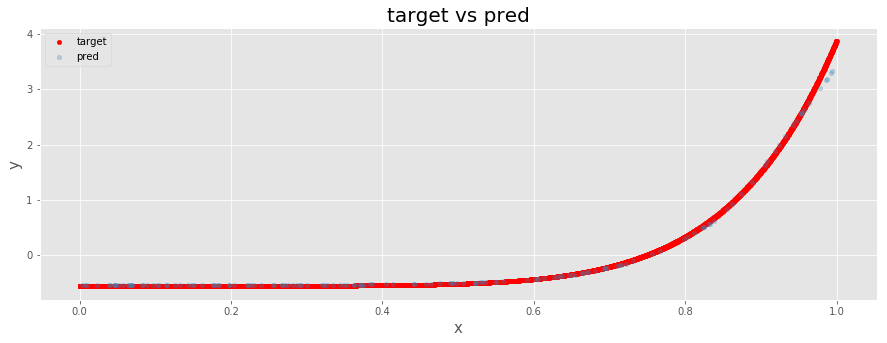

In [78]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))

# Chart 1 - Shows the line we are trying to model
df.plot.scatter(x='train_x', y='train_y', ax=axes, color='red')

# Chart 2 - Shows the line our trained model came up with
df_final.plot.scatter(x='test_x', y='pred', ax=axes, alpha=0.3)

# add a little sugar
axes.set_title('target vs pred', fontsize=20)
axes.set_ylabel('y', fontsize=15)
axes.set_xlabel('x', fontsize=15)
axes.legend(["target", "pred"], loc='best');

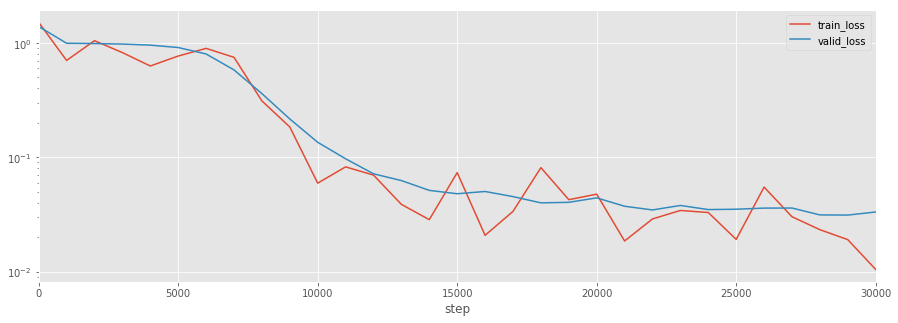

In [79]:
df_loss.set_index('step').plot(logy=True, figsize=(15,5))